In [127]:
!pip install scipy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install torch
!pip install torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.4 MB/s eta 0:00:000:00:010:00:0101


In [1]:
import scipy.io
import numpy as np
import random
import csv
import json

# Caminho para o .mat do MPII
mat_file = 'dados/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat'
data = scipy.io.loadmat(mat_file)

# Acessa a estrutura 'RELEASE'
release = data['RELEASE'][0, 0]
annolist = release['annolist'][0]
actions = release['act'][0]


In [2]:
actions = release['act']
action_map = {}

for i, act in enumerate(actions):
    if len(act) > 0 and len(act[0]) == 3:
        act_name_arr = act[0][0]  # 1º elemento da tupla
        if len(act_name_arr) > 0:
            action_name = act_name_arr[0]
            if isinstance(action_name, bytes):
                action_name = action_name.decode()
            if action_name not in action_map:
                action_map[action_name] = []
            action_map[action_name].append(i)


In [3]:
print(f"{'Rótulo':<20} | {'Quantidade':>10}")
print('-'*33)
for action, indices in action_map.items():
    print(f"{action:<20} | {len(indices):>10}")

Rótulo               | Quantidade
---------------------------------
sports               |       3593
inactivity quiet/light |        189
miscellaneous        |        755
occupation           |       2412
water activities     |       1066
home activities      |       1416
lawn and garden      |       1130
religious activities |        124
winter activities    |        778
conditioning exercise |       1755
bicycling            |        533
fishing and hunting  |        725
dancing              |        722
walking              |        608
running              |        316
self care            |         90
home repair          |       1090
volunteer activities |         55
music playing        |        583
transportation       |         93


In [87]:
#A base tem diferentes tipos de classes, algumas vazias
# Filtra ações com ao menos 100 amostras e escolhe 3 aleatoriamente
eligible_actions = [a for a, idxs in action_map.items() if len(idxs) >= 100]
random.seed(42)  # Define a semente para reprodutibilidade
chosen_actions = random.sample(eligible_actions, 3)
print("Ações escolhidas:", chosen_actions)


Ações escolhidas: [np.str_('occupation'), np.str_('sports'), np.str_('fishing and hunting')]


In [21]:
def extract_keypoints(annorect):
    keypoints = []
    
    if 'annopoints' in annorect.dtype.names:
        annopoints = annorect['annopoints']
        
        if annopoints.size > 0 and annopoints[0] is not None:
            points_struct = annopoints[0][0]  # acessa estrutura interna
            
            if 'point' in points_struct.dtype.names:
                points = points_struct['point']
                
                if points.size > 0:
                    points = points[0]  # array de pontos
                    for pt in points:
                        try:
                            x = float(pt['x'][0][0])
                            y = float(pt['y'][0][0])
                            kp_id = int(pt['id'][0][0])
                            vis = int(pt['is_visible'][0][0]) if 'is_visible' in pt.dtype.names and pt['is_visible'].size > 0 else -1
                            keypoints.append({
                                'id': kp_id,
                                'x': x,
                                'y': y,
                                'visible': vis
                            })
                        except Exception as e:
                            print(f"Erro no ponto: {e}")
    return keypoints


In [79]:
idx = 21147
img_data = annolist[idx]
annorects = img_data['annorect']

# Encontra o nome da ação associada a esse índice
action_name = None
for action, indices in action_map.items():
    if idx in indices:
        action_name = action
        break

print(f"Índice {idx} corresponde à ação: '{action_name}'\n")

# Agora extrai os keypoints
for i, person in enumerate(annorects[0]):
    keypoints = extract_keypoints(person)
    print(f"Pessoa {i}: {len(keypoints)} keypoints")
    print(keypoints)


Índice 21147 corresponde à ação: 'water activities'

Pessoa 0: 16 keypoints
[{'id': 6, 'x': 438.0, 'y': 342.0, 'visible': 0}, {'id': 7, 'x': 398.0, 'y': 321.0, 'visible': 0}, {'id': 8, 'x': 400.3144, 'y': 322.4026, 'visible': -1}, {'id': 9, 'x': 362.6856, 'y': 299.5974, 'visible': -1}, {'id': 0, 'x': 414.0, 'y': 441.0, 'visible': 0}, {'id': 1, 'x': 400.0, 'y': 395.0, 'visible': 1}, {'id': 2, 'x': 423.0, 'y': 344.0, 'visible': 0}, {'id': 3, 'x': 453.0, 'y': 339.0, 'visible': 1}, {'id': 4, 'x': 459.0, 'y': 404.0, 'visible': 1}, {'id': 5, 'x': 488.0, 'y': 401.0, 'visible': 1}, {'id': 10, 'x': 343.0, 'y': 362.0, 'visible': 1}, {'id': 11, 'x': 367.0, 'y': 340.0, 'visible': 1}, {'id': 12, 'x': 384.0, 'y': 314.0, 'visible': 0}, {'id': 13, 'x': 411.0, 'y': 327.0, 'visible': 1}, {'id': 14, 'x': 423.0, 'y': 366.0, 'visible': 1}, {'id': 15, 'x': 403.0, 'y': 411.0, 'visible': 1}]


In [90]:
samples = []
samples_per_action = 100
min_keypoints = 10  # ou 10, conforme sua necessidade

for action in chosen_actions:
    collected = 0
    available_indices = list(action_map[action])
    random.seed(42) 
    random.shuffle(available_indices)  # aleatoriza os índices

    for idx in available_indices:
        img_data = annolist[idx]
        img_name = img_data['image']['name'][0]

        if img_data['annorect'].size > 0:
            annorects = img_data['annorect']
            for p, person in enumerate(annorects[0]):
                keypoints = extract_keypoints(person)
                if len(keypoints) >= min_keypoints:
                    samples.append({
                        'image': img_name,
                        'action': action,
                        'person_index': p,
                        'keypoints': json.dumps(keypoints)
                    })
                    collected += 1
                    break # só 1 pessoa por imagem

        if collected >= samples_per_action:
            break  # já coletou o suficiente

    print(f"Ação '{action}': {collected} amostras coletadas.")


Ação 'occupation': 100 amostras coletadas.
Ação 'sports': 100 amostras coletadas.
Ação 'fishing and hunting': 100 amostras coletadas.


In [91]:
samples

[{'image': array([array(['065550997.jpg'], dtype='<U13')], dtype=object),
  'action': np.str_('occupation'),
  'person_index': 0,
  'keypoints': '[{"id": 6, "x": 731.0, "y": 119.0, "visible": 0}, {"id": 7, "x": 574.0, "y": 187.0, "visible": 0}, {"id": 8, "x": 539.8756, "y": 209.4354, "visible": -1}, {"id": 9, "x": 427.1244, "y": 283.5646, "visible": -1}, {"id": 0, "x": 702.0, "y": 535.0, "visible": 1}, {"id": 1, "x": 669.0, "y": 340.0, "visible": 0}, {"id": 2, "x": 700.0, "y": 127.0, "visible": 0}, {"id": 3, "x": 762.0, "y": 111.0, "visible": 1}, {"id": 4, "x": 787.0, "y": 330.0, "visible": 1}, {"id": 5, "x": 869.0, "y": 555.0, "visible": 1}, {"id": 10, "x": 460.0, "y": 458.0, "visible": 1}, {"id": 11, "x": 485.0, "y": 326.0, "visible": 1}, {"id": 12, "x": 535.0, "y": 171.0, "visible": 0}, {"id": 13, "x": 613.0, "y": 202.0, "visible": 1}, {"id": 14, "x": 638.0, "y": 377.0, "visible": 1}, {"id": 15, "x": 574.0, "y": 497.0, "visible": 1}]'},
 {'image': array([array(['045876829.jpg'], dty

In [110]:
import pandas as pd

#Distribuição das classes
df = pd.DataFrame(samples)
df['action'].value_counts()


action
occupation             100
sports                 100
fishing and hunting    100
Name: count, dtype: int64

In [107]:
#Distribuição e media do número de keypoints por classe
df['n_keypoints'] = df['keypoints'].apply(lambda kps: len(json.loads(kps)))
df.groupby('action')['n_keypoints'].describe()

,count,mean,std,min,25%,50%,75%,max
action,,,,,,,,
fishing and hunting,100.0,14.70,1.623688,10.0,14.0,16.0,16.0,16.0
occupation,100.0,14.64,1.789532,10.0,13.0,16.0,16.0,16.0
sports,100.0,15.50,1.210226,12.0,16.0,16.0,16.0,16.0


In [106]:
#Distribuição de Keypoints por parte do corpo
import pandas as pd
from collections import Counter

# Contar frequência dos keypoints
all_kps = []
for row in df['keypoints']:
    all_kps.extend([kp['id'] for kp in json.loads(row)])

kp_counts = Counter(all_kps)

# Legenda dos keypoints
kp_names = {
    0: "R_ankle", 1: "R_knee", 2: "R_hip", 3: "L_hip",
    4: "L_knee", 5: "L_ankle", 6: "Pelvis", 7: "Thorax",
    8: "Upper_neck", 9: "Head_top", 10: "R_wrist", 11: "R_elbow",
    12: "R_shoulder", 13: "L_shoulder", 14: "L_elbow", 15: "L_wrist"
}

# Criar dataframe
kp_table = pd.DataFrame([
    {"id": k, "keypoint": kp_names.get(k, f"kp_{k}"), "count": v}
    for k, v in kp_counts.items()
]).sort_values(by="count", ascending=False).reset_index(drop=True)


kp_table


,id,keypoint,count
0,7,Thorax,300
1,8,Upper_neck,300
2,9,Head_top,300
3,11,R_elbow,300
4,12,R_shoulder,300
5,13,L_shoulder,300
6,14,L_elbow,300
7,3,L_hip,299
8,10,R_wrist,299
9,2,R_hip,298


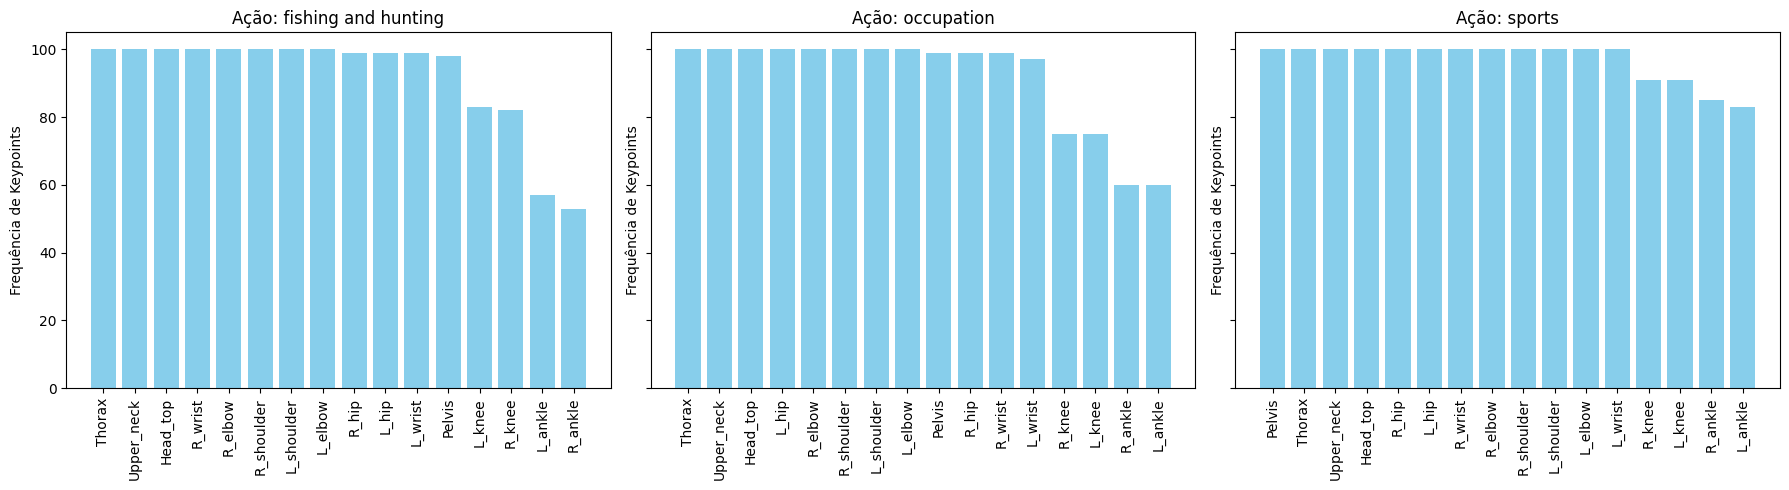

In [118]:
import pandas as pd
from collections import Counter, defaultdict

# Legenda dos keypoints
kp_names = {
    0: "R_ankle", 1: "R_knee", 2: "R_hip", 3: "L_hip",
    4: "L_knee", 5: "L_ankle", 6: "Pelvis", 7: "Thorax",
    8: "Upper_neck", 9: "Head_top", 10: "R_wrist", 11: "R_elbow",
    12: "R_shoulder", 13: "L_shoulder", 14: "L_elbow", 15: "L_wrist"
}

# Inicializar dicionário para contar keypoints por ação
kp_action_counts = defaultdict(Counter)

# Iterar sobre o DataFrame e contar keypoints por classe
for _, row in df.iterrows():
    action = row['action']
    keypoints = json.loads(row['keypoints'])
    for kp in keypoints:
        kp_action_counts[action][kp['id']] += 1

# Transformar em DataFrame "long" para facilitar visualização
data = []
for action, counts in kp_action_counts.items():
    for kp_id, count in counts.items():
        data.append({
            'action': action,
            'id': kp_id,
            'keypoint': kp_names.get(kp_id, f"kp_{kp_id}"),
            'count': count
        })

kp_action_table = pd.DataFrame(data).sort_values(by=["action", "count"], ascending=[True, False]).reset_index(drop=True)


# Identificar ações únicas
actions = kp_action_table['action'].unique()

# Criar subplots lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, action in enumerate(actions):
    df_action = kp_action_table[kp_action_table['action'] == action]
    axes[i].bar(df_action['keypoint'], df_action['count'], color='skyblue')
    axes[i].set_title(f"Ação: {action}")
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_ylabel("Frequência de Keypoints")

plt.tight_layout()
plt.show()




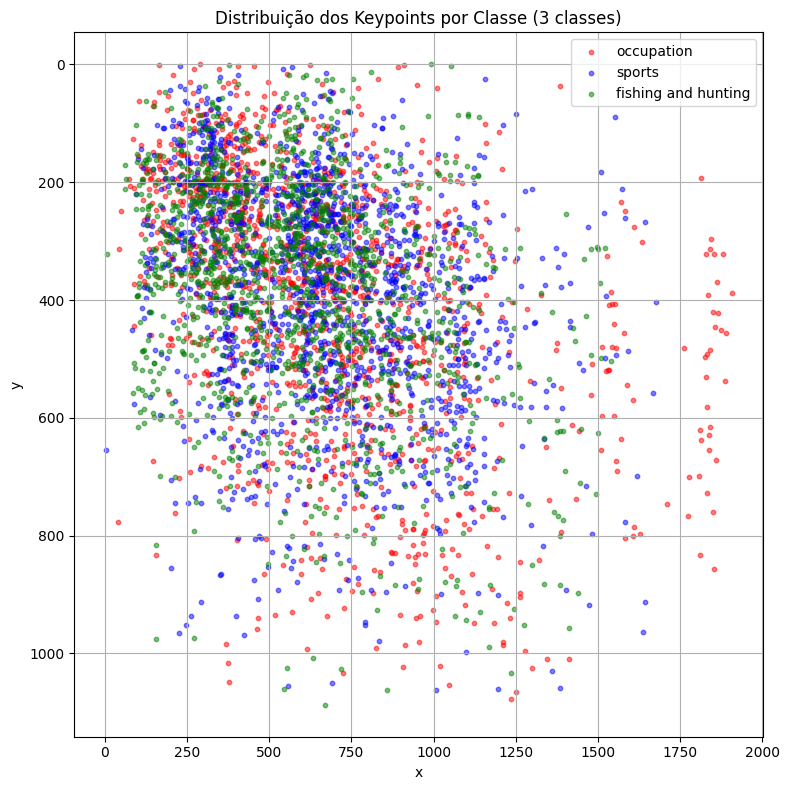

In [121]:
import matplotlib.pyplot as plt
import json

plt.figure(figsize=(8, 8))

actions = df['action'].unique()

# Definindo cores manualmente, bem contrastantes
colors_map = {
    actions[0]: 'red',
    actions[1]: 'blue',
    actions[2]: 'green'
}

for action in actions:
    xs = []
    ys = []
    for row in df[df['action'] == action]['keypoints']:
        for kp in json.loads(row):
            xs.append(kp['x'])
            ys.append(kp['y'])
    
    plt.scatter(xs, ys, alpha=0.5, label=action, color=colors_map[action], s=10)

plt.title("Distribuição dos Keypoints por Classe (3 classes)")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


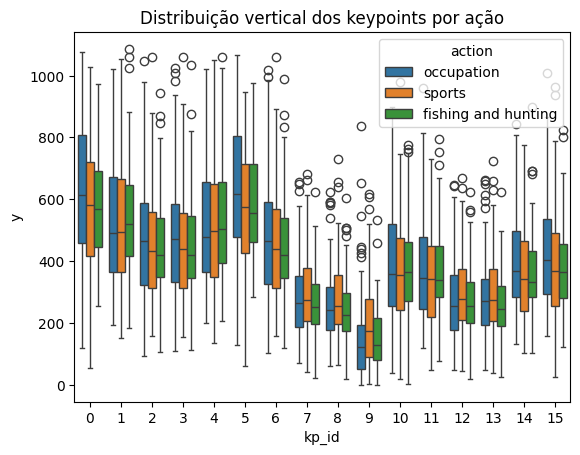

In [103]:
import seaborn as sns

df_expanded = []
for _, row in df.iterrows():
    for kp in json.loads(row['keypoints']):
        df_expanded.append({
            'action': row['action'],
            'kp_id': kp['id'],
            'x': kp['x'],
            'y': kp['y'],
            'visible': kp['visible']
        })

df_kp = pd.DataFrame(df_expanded)

sns.boxplot(x='kp_id', y='y', hue='action', data=df_kp)
plt.title("Distribuição vertical dos keypoints por ação")
plt.show()


In [165]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import numpy as np

class PoseDataset(Dataset):
    def __init__(self, samples, images_dir, action_to_idx, image_size=(256,256), transform=None, max_keypoints=16):
        self.samples = samples
        self.images_dir = images_dir
        self.action_to_idx = action_to_idx
        self.image_size = image_size
        self.max_keypoints = max_keypoints
        
        if transform is None:
            self.transform = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485,0.456,0.406],
                            std=[0.229,0.224,0.225])
            ])
        else:
            self.transform = transform
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        img_name = sample['image']
        while isinstance(img_name, np.ndarray):
            img_name = img_name.item()
        
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        original_size = image.size
        
        image = image.resize(self.image_size)
        
        # Processar keypoints (normalizar e máscara visibilidade)
        keypoints = json.loads(sample['keypoints'])
        normalized_kps = []
        for kp in keypoints:
            norm_x = kp['x'] / original_size[0]
            norm_y = kp['y'] / original_size[1]
            vis = 1 if kp['visible'] > 0 else 0
            normalized_kps.append([norm_x, norm_y, vis])
        
        # Padronizar quantidade de keypoints
        while len(normalized_kps) < self.max_keypoints:
            normalized_kps.append([0.,0.,0.])
        normalized_kps = normalized_kps[:self.max_keypoints]
        
        keypoints_tensor = torch.tensor(normalized_kps, dtype=torch.float32)
        
        image = self.transform(image)
        
        label = self.action_to_idx[sample['action']]
        
        return image, keypoints_tensor, label


In [166]:
# Mapear ações para índices
actions = sorted(set(s['action'] for s in samples))
action_to_idx = {a: i for i, a in enumerate(actions)}

# Instanciar Dataset
dataset = PoseDataset(samples, images_dir='dados/mpii_human_pose_v1/images', action_to_idx=action_to_idx)

# Testar um item
img, kps, lbl = dataset[0]
print(img.shape, kps.shape, lbl)


torch.Size([3, 256, 256]) torch.Size([16, 3]) 1


In [167]:
import numpy as np
import matplotlib.pyplot as plt

# Escolher um índice (exemplo: o primeiro)
idx = 10

# Pegar os dados do dataset
img_tensor, keypoints_tensor, label = dataset[idx]

print("Tensor da imagem ")
print(img_tensor)
print("\nTensor dos keypoints (N_keypoints, 3 [x,y,visibility]):")
print(keypoints_tensor)
print("\nLabel (índice da classe):", label)

# Converter tensor para numpy e rearranjar canais para (H, W, C)
img_np = img_tensor.permute(1, 2, 0).numpy()

print("\nShape da imagem numpy:", img_np.shape)  # Exemplo: (altura, largura, canais)
print("Matriz de pixels (array):")
print(img_np)



Tensor da imagem 
tensor([[[2.0605, 2.0605, 2.0777,  ..., 2.1290, 2.1462, 2.1290],
         [2.0605, 2.0605, 2.0777,  ..., 2.1290, 2.1462, 2.1290],
         [2.0605, 2.0777, 2.0777,  ..., 2.1290, 2.1290, 2.1290],
         ...,
         [2.0948, 2.0948, 2.0777,  ..., 2.1290, 2.1290, 2.1290],
         [2.0605, 2.0948, 2.0605,  ..., 2.0948, 2.1119, 2.1290],
         [2.0605, 2.0948, 2.0605,  ..., 2.0948, 2.0948, 2.0948]],

        [[2.2535, 2.2535, 2.2710,  ..., 2.3585, 2.3761, 2.3585],
         [2.2535, 2.2535, 2.2710,  ..., 2.3585, 2.3761, 2.3585],
         [2.2535, 2.2710, 2.2710,  ..., 2.3585, 2.3585, 2.3585],
         ...,
         [2.3060, 2.3060, 2.3410,  ..., 2.3585, 2.3585, 2.3585],
         [2.2710, 2.3060, 2.3235,  ..., 2.3585, 2.3410, 2.3585],
         [2.2710, 2.3060, 2.3235,  ..., 2.3585, 2.3235, 2.3235]],

        [[2.3611, 2.3611, 2.3960,  ..., 2.4483, 2.4657, 2.4483],
         [2.3611, 2.3611, 2.3960,  ..., 2.4483, 2.4657, 2.4483],
         [2.3611, 2.3786, 2.3960,  ..., 

In [168]:
# Converter tensor para numpy e rearranjar canais para (H, W, C)
img_np = img_tensor.permute(1, 2, 0).numpy()

print("\nShape da imagem numpy:", img_np.shape)  # Exemplo: (altura, largura, canais)
print("Matriz de pixels (array):")
print(img_np)



Shape da imagem numpy: (256, 256, 3)
Matriz de pixels (array):
[[[2.060536  2.2535014 2.3611329]
  [2.060536  2.2535014 2.3611329]
  [2.0776608 2.2710083 2.3959913]
  ...
  [2.129035  2.3585434 2.4482791]
  [2.1461596 2.3760502 2.465708 ]
  [2.129035  2.3585434 2.4482791]]

 [[2.060536  2.2535014 2.3611329]
  [2.060536  2.2535014 2.3611329]
  [2.0776608 2.2710083 2.3959913]
  ...
  [2.129035  2.3585434 2.4482791]
  [2.1461596 2.3760502 2.465708 ]
  [2.129035  2.3585434 2.4482791]]

 [[2.060536  2.2535014 2.3611329]
  [2.0776608 2.2710083 2.3785625]
  [2.0776608 2.2710083 2.3959913]
  ...
  [2.129035  2.3585434 2.4482791]
  [2.129035  2.3585434 2.4482791]
  [2.129035  2.3585434 2.4482791]]

 ...

 [[2.0947855 2.3060222 2.4308496]
  [2.0947855 2.3060222 2.4308496]
  [2.0776608 2.3410363 2.465708 ]
  ...
  [2.129035  2.3585434 2.4482791]
  [2.129035  2.3585434 2.4482791]
  [2.129035  2.3585434 2.4482791]]

 [[2.060536  2.2710083 2.3959913]
  [2.0947855 2.3060222 2.4308496]
  [2.060536  2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


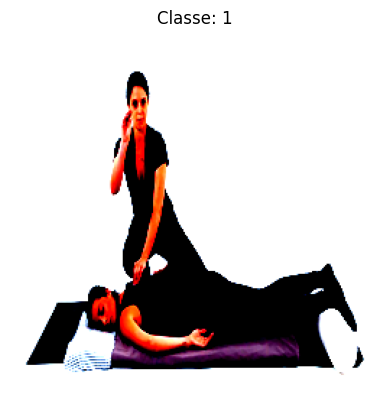

In [169]:

# Mostrar a imagem para conferir
plt.imshow(img_np)
plt.title(f"Classe: {label}")
plt.axis('off')
plt.show()

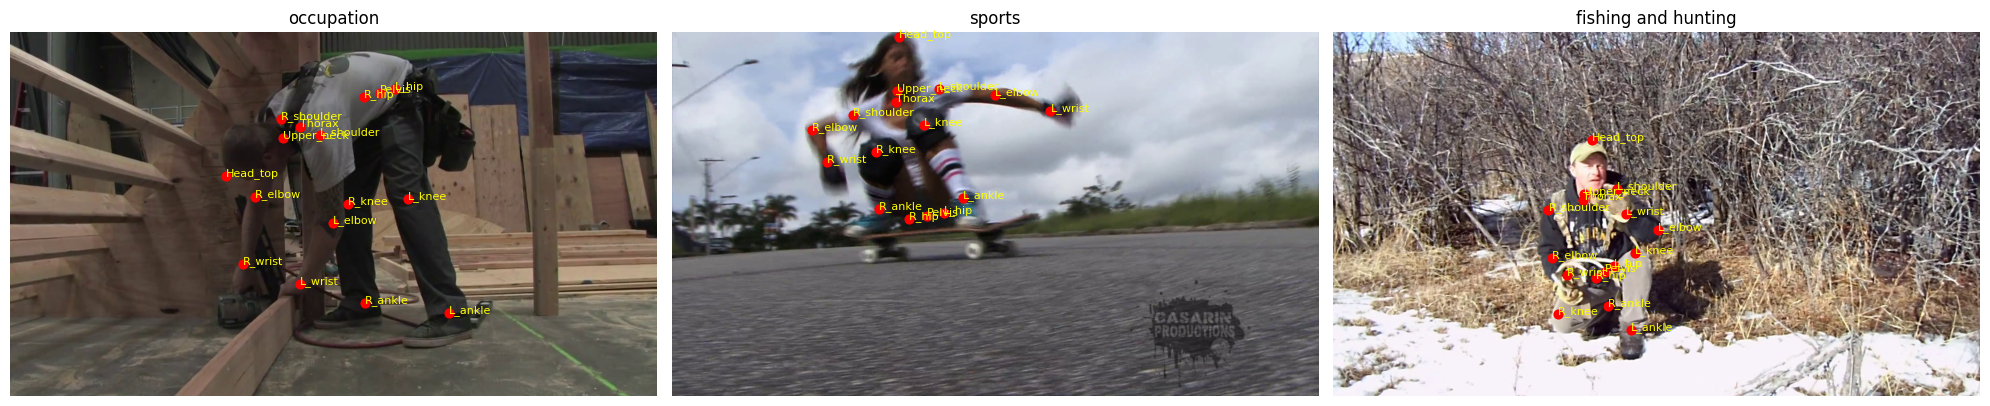

In [170]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
import numpy as np

# Função que plota a imagem a partir do tensor desnormalizado e sobrepõe keypoints
def plot_keypoints_on_tensor(img_tensor, keypoints, kp_names=None):
    mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)

    img_np = img_tensor.numpy()
    img_np = (img_np * std) + mean
    img_np = np.clip(img_np, 0, 1)
    img_np = np.transpose(img_np, (1, 2, 0))  # C,H,W -> H,W,C

    plt.imshow(img_np)
    xs = [kp['x'] for kp in keypoints]
    ys = [kp['y'] for kp in keypoints]
    plt.scatter(xs, ys, c='red', s=40)
    if kp_names:
        for kp in keypoints:
            plt.text(kp['x'], kp['y'], kp_names.get(kp['id'], str(kp['id'])), color='yellow', fontsize=8)
    plt.axis('off')

# Transformação para converter PIL Image para tensor normalizado
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

seen_classes = set()
fig, axs = plt.subplots(1, len(action_to_idx), figsize=(20, 5))

for i, sample in enumerate(samples):
    action = sample['action']
    if action in seen_classes:
        continue

    img_name = sample['image']
    while isinstance(img_name, np.ndarray):
        img_name = img_name.item()

    img_path = os.path.join('dados/mpii_human_pose_v1/images', img_name)
    img = Image.open(img_path).convert('RGB')

    # Converter para tensor normalizado
    img_tensor = transform(img)

    keypoints = json.loads(sample['keypoints'])

    plt.sca(axs[len(seen_classes)])
    plot_keypoints_on_tensor(img_tensor, keypoints, kp_names)
    axs[len(seen_classes)].set_title(action)

    seen_classes.add(action)
    if len(seen_classes) == len(action_to_idx):
        break

plt.tight_layout()
plt.show()


In [171]:
import csv
import numpy as np

def save_samples_to_csv(samples, csv_path):
    # Abrir arquivo CSV para escrita
    with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Escrever cabeçalho
        writer.writerow(['image', 'action', 'person_index', 'keypoints'])
        
        for sample in samples:
            # Para 'image' pode ser ndarray, desempacotar para string
            img_name = sample['image']
            if isinstance(img_name, np.ndarray):
                img_name = img_name.item()
            
            # Escrever linha
            writer.writerow([
                img_name,
                str(sample['action']),
                sample['person_index'],
                sample['keypoints']
            ])

# Exemplo de uso:
save_samples_to_csv(samples, 'dados/dataset_pose.csv')
print("CSV criado com sucesso!")


CSV criado com sucesso!
